In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('/content/drive/MyDrive/NNFL-Assignment1/data_q4_q5.csv')
df = df.replace({'diagnosis': {'B': 0, 'M': 1}})
df.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,1
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,1
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,1
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,1
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,1


In [4]:
df = df.drop_duplicates(keep='first')
df = df.sample(frac = 1).reset_index(drop=True)
m = df.shape[0]
n = df.shape[1] - 1
print(m,n)
df.head()

569 30


,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,diagnosis
0,13.61,24.98,88.05,582.7,0.09488,0.08511,0.08625,0.04489,0.1609,0.05871,0.4565,1.2900,2.861,43.14,0.005872,0.014880,0.02647,0.009921,0.01465,0.002355,16.99,35.27,108.60,906.5,0.1265,0.19430,0.31690,0.11840,0.2651,0.07397,1
1,15.70,20.31,101.20,766.6,0.09597,0.08799,0.06593,0.05189,0.1618,0.05549,0.3699,1.1500,2.406,40.98,0.004626,0.022630,0.01954,0.009767,0.01547,0.002430,20.11,32.82,129.30,1269.0,0.1414,0.35470,0.29020,0.15410,0.3437,0.08631,1
2,11.31,19.04,71.80,394.1,0.08139,0.04701,0.03709,0.02230,0.1516,0.05667,0.2727,0.9429,1.831,18.15,0.009282,0.009216,0.02063,0.008965,0.02183,0.002146,12.33,23.84,78.00,466.7,0.1290,0.09148,0.14440,0.06961,0.2400,0.06641,0
3,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.040060,0.03832,0.020580,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.42450,0.45040,0.24300,0.3613,0.08758,1
4,11.15,13.08,70.87,381.9,0.09754,0.05113,0.01982,0.01786,0.1830,0.06105,0.2251,0.7815,1.429,15.48,0.009019,0.008985,0.01196,0.008232,0.02388,0.001619,11.99,16.30,76.25,440.8,0.1341,0.08971,0.07116,0.05506,0.2859,0.06772,0


In [5]:
datan = df.values
X = datan[:, 0:30]
#X = (X - np.min(X, axis = 0))/(np.max(X, axis=0)-np.min(X, axis=0))
X = (X - X.mean(axis = 0))/(X.std(axis = 0))
X = np.append(np.ones([m,1]), X, axis = 1)

y = datan[:, -1]# M -> 1, B -> 0  

w = np.zeros(n+1)
print(X.shape, y.shape)

(569, 31) (569,)


In [6]:
num_classes = len(np.unique(y))
print(num_classes)

2


In [7]:
def plot_gd(costs):
  plt.title('Cost Function vs epochs')
  plt.xlabel('Iterations')
  plt.ylabel('Cost')
  plt.plot(costs)
  plt.show()

In [8]:
def sigmoid(X, w):
  z = np.dot(X, w.T)
  return 1/(1+np.exp(-z.astype(float)))

In [9]:
def cost_L1(X, y, w, lm):
  m = len(y)
  h = sigmoid(X, w)
  return (-1/m)*np.sum(np.multiply(y, np.log(h))+ np.multiply(1-y, np.log(1-h))) + lm*np.sum(abs(w))

In [10]:
def cost_L2(X, y, w, lm):
  m = len(y)
  h = sigmoid(X, w)
  return (-1/m)*np.sum(np.multiply(y, np.log(h))+ np.multiply(1-y, np.log(1-h))) + (lm/(2))*np.sum((w)**2)

In [11]:
def bgd_L2(X, y, w, alpha, T, lm):
  costs = np.zeros(T)
  weights = np.zeros((T,31))
  m = len(y)
  for i in range(T):
    h = sigmoid(X, w)
    w = w*(1-alpha*lm) - (alpha/m)*np.dot(h-y,X)
    costs[i] = cost_L2(X, y, w, lm)
    weights[i, :] = w
  return costs, weights, w
################################################
def sgd_L2(X, y, w, alpha, T, lm):
    costs = np.zeros(T)
    weights = np.zeros((T,31))
    m = len(y)
    for i in range(T):
        rand_index = np.random.randint(m)
        ind_x = X[rand_index:rand_index+1]
        ind_y = y[rand_index:rand_index+1]
        z = ind_x.dot(w)
        h = 1/(1+np.exp(-z.astype(float)))
        w = w*(1-alpha*lm) - alpha * (ind_x.T.dot(h - ind_y))
        costs[i] = cost_L2(ind_x,ind_y,w, lm)
        weights[i, :] = w
    return costs, weights, w
################################################
def mbgd_L2(X, y, w, alpha, T, batch_size, lm):
    costs = np.zeros(T)
    weights = np.zeros((T,31))
    m = len(y)
    for i in range(T):
        rand_index = np.random.randint(m)
        ind_x = X[rand_index:rand_index+batch_size]
        ind_y = y[rand_index:rand_index+batch_size]
        z = ind_x.dot(w)
        h = 1/(1+np.exp(-z.astype(float)))
        w = w*(1-alpha*lm) - (alpha/batch_size) * (ind_x.T.dot(h - ind_y))
        costs[i] = cost_L2(ind_x,ind_y,w, lm)
        weights[i, :] = w
    return costs, weights, w

In [12]:
def bgd_L1(X, y, w, alpha, T, lm):
  costs = np.zeros(T)
  weights = np.zeros((T,31))
  m = len(y)
  for i in range(T):
    h = sigmoid(X, w)
    w = w - (alpha*lm/2)*(np.sign(w)) - (alpha/m)*np.dot(h-y,X)
    costs[i] = cost_L1(X, y, w, lm)
    weights[i, :] = w
  return costs, weights, w
################################################
def sgd_L1(X, y, w, alpha, T, lm):
    costs = np.zeros(T)
    weights = np.zeros((T,31))
    m = len(y)
    for i in range(T):
        rand_index = np.random.randint(m)
        ind_x = X[rand_index:rand_index+1]
        ind_y = y[rand_index:rand_index+1]
        z = ind_x.dot(w)
        h = 1/(1+np.exp(-z.astype(float)))
        w = w - (alpha*lm/2)*(np.sign(w)) - alpha * (ind_x.T.dot(h - ind_y))
        costs[i] = cost_L1(ind_x,ind_y,w, lm)
        weights[i, :] = w
    return costs, weights, w
################################################
def mbgd_L1(X, y, w, alpha, T, batch_size, lm):
    costs = np.zeros(T)
    weights = np.zeros((T,31))
    m = len(y)
    for i in range(T):
        rand_index = np.random.randint(m)
        ind_x = X[rand_index:rand_index+batch_size]
        ind_y = y[rand_index:rand_index+batch_size]
        z = ind_x.dot(w)
        h = 1/(1+np.exp(-z.astype(float)))
        w = w - (alpha*lm/2)*(np.sign(w)) - (alpha/batch_size) * (ind_x.T.dot(h - ind_y))
        costs[i] = cost_L1(ind_x,ind_y,w, lm)
        weights[i, :] = w
    return costs, weights, w

In [13]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1)
print(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)

(409, 31) (46, 31) (114, 31) (409,) (46,) (114,)


In [14]:
alpha_vals = np.linspace(0.01, 0.1, 35).tolist()
lm_vals = np.linspace(0.01, 0.1, 10).tolist()

In [15]:
def grid_search_bgd_L1(X_train, X_val, y_train, y_val, w, alpha_vals, T, lm_vals):
  alpha_vals
  acc_max = 0
  alpha_best, lm_best = 0, 0
  for i in alpha_vals:
    for j in lm_vals:
      costs_bgd_L1, weights_bgd_L1, w_bgd_L1 = bgd_L1(X_train, y_train, w, i, T, j)
      predictions = np.round_(sigmoid(X_val, w_bgd_L1))
      TN, TP, FN, FP = 0, 0, 0, 0
      for k in range(len(y_val)):
        if (predictions[k] == 0 and y_val[k] == 0):
          TN = TN + 1
        elif (predictions[k] == 1 and y_val[k] == 1):
          TP = TP + 1
        elif (predictions[k] == 0 and y_val[k] == 1):
          FN = FN + 1
        elif (predictions[k] == 1 and y_val[k] == 0):
          FP = FP + 1
      acc = (TP + TN)/(TP + TN + FN + FP)

      if(acc > acc_max):
        acc_max = acc
        alpha_best = i
        lm_best = j
  return alpha_best, lm_best

def grid_search_sgd_L1(X_train, X_val, y_train, y_val, w, alpha_vals, T, lm_vals):
  acc_max = 0
  alpha_best, lm_best = 0, 0
  for i in alpha_vals:
    for j in lm_vals:
      costs_sgd_L1, weights_sgd_L1, w_sgd_L1 = sgd_L1(X_train, y_train, w, i, T, j)
      predictions = np.round_(sigmoid(X_val, w_sgd_L1))
      TN, TP, FN, FP = 0, 0, 0, 0
      for k in range(len(y_val)):
        if (predictions[k] == 0 and y_val[k] == 0):
          TN = TN + 1
        elif (predictions[k] == 1 and y_val[k] == 1):
          TP = TP + 1
        elif (predictions[k] == 0 and y_val[k] == 1):
          FN = FN + 1
        elif (predictions[k] == 1 and y_val[k] == 0):
          FP = FP + 1
      acc = (TP + TN)/(TP + TN + FN + FP)

      if(acc > acc_max):
        acc_max = acc
        alpha_best = i
        lm_best = j
  return alpha_best, lm_best

def grid_search_mbgd_L1(X_train, X_val, y_train, y_val, w, alpha_vals, T, batch_size, lm_vals):
  acc_max = 0
  alpha_best, lm_best = 0, 0
  for i in alpha_vals:
    for j in lm_vals:
      costs_mbgd_L1, weights_mbgd_L1, w_mbgd_L1 = mbgd_L1(X_train, y_train, w, i, T, batch_size, j)
      predictions = np.round_(sigmoid(X_val, w_mbgd_L1))
      TN, TP, FN, FP = 0, 0, 0, 0
      for k in range(len(y_val)):
        if (predictions[k] == 0 and y_val[k] == 0):
          TN = TN + 1
        elif (predictions[k] == 1 and y_val[k] == 1):
          TP = TP + 1
        elif (predictions[k] == 0 and y_val[k] == 1):
          FN = FN + 1
        elif (predictions[k] == 1 and y_val[k] == 0):
          FP = FP + 1
      acc = (TP + TN)/(TP + TN + FN + FP)

      if(acc > acc_max):
        acc_max = acc
        alpha_best = i
        lm_best = j
  return alpha_best, lm_best

In [16]:
def grid_search_bgd_L2(X_train, X_val, y_train, y_val, w, alpha_vals, T, lm_vals):
  acc_max = 0
  alpha_best = 0
  lm_best = 0
  for i in alpha_vals:
    for j in lm_vals:
      costs_bgd_L2, weights_bgd_L2, w_bgd_L2 = bgd_L2(X_train, y_train, w, i, T, j)
      predictions = np.round_(sigmoid(X_val, w_bgd_L2))
      TN, TP, FN, FP = 0, 0, 0, 0
      for k in range(len(y_val)):
        if (predictions[k] == 0 and y_val[k] == 0):
          TN = TN + 1
        elif (predictions[k] == 1 and y_val[k] == 1):
          TP = TP + 1
        elif (predictions[k] == 0 and y_val[k] == 1):
          FN = FN + 1
        elif (predictions[k] == 1 and y_val[k] == 0):
          FP = FP + 1
      acc = (TP + TN)/(TP + TN + FN + FP)

      if(acc > acc_max):
        acc_max = acc
        alpha_best = i
        lm_best = j
  return alpha_best, lm_best

def grid_search_sgd_L2(X_train, X_val, y_train, y_val, w, alpha_vals, T, lm_vals):
  acc_max = 0
  alpha_best, lm_best = 0, 0
  for i in alpha_vals:
    for j in lm_vals:
      costs_sgd_L2, weights_sgd_L2, w_sgd_L2 = sgd_L2(X_train, y_train, w, i, T, j)
      predictions = np.round_(sigmoid(X_val, w_sgd_L2))
      TN, TP, FN, FP = 0, 0, 0, 0
      for k in range(len(y_val)):
        if (predictions[k] == 0 and y_val[k] == 0):
          TN = TN + 1
        elif (predictions[k] == 1 and y_val[k] == 1):
          TP = TP + 1
        elif (predictions[k] == 0 and y_val[k] == 1):
          FN = FN + 1
        elif (predictions[k] == 1 and y_val[k] == 0):
          FP = FP + 1
      acc = (TP + TN)/(TP + TN + FN + FP)

      if(acc > acc_max):
        acc_max = acc
        alpha_best = i
        lm_best = j
  return alpha_best, lm_best

def grid_search_mbgd_L2(X_train, X_val, y_train, y_val, w, alpha_vals, T, batch_size, lm_vals):
  acc_max = 0
  alpha_best, lm_best = 0, 0
  for i in alpha_vals:
    for j in lm_vals:
      costs_mbgd_L2, weights_mbgd_L2, w_mbgd_L2 = mbgd_L2(X_train, y_train, w, i, T, batch_size, j)
      predictions = np.round_(sigmoid(X_val, w_mbgd_L2))
      TN, TP, FN, FP = 0, 0, 0, 0
      for k in range(len(y_val)):
        if (predictions[k] == 0 and y_val[k] == 0):
          TN = TN + 1
        elif (predictions[k] == 1 and y_val[k] == 1):
          TP = TP + 1
        elif (predictions[k] == 0 and y_val[k] == 1):
          FN = FN + 1
        elif (predictions[k] == 1 and y_val[k] == 0):
          FP = FP + 1
      acc = (TP + TN)/(TP + TN + FN + FP)

      if(acc > acc_max):
        acc_max = acc
        alpha_best = i
        lm_best = j
  return alpha_best, lm_best

In [17]:
def confusion_matrix(predictions, labels):
  TP = 0
  FN = 0
  FP = 0
  TN = 0
  m = len(labels)

  for i in range(m):
      if labels[i] == 0 and predictions[i] == 0:
              TN = TN + 1
      if labels[i] == 1 and predictions[i] == 0:
              FN = FN + 1
      if labels[i] == 0 and predictions[i] == 1:
              FP = FP + 1
      if predictions[i] == 1 and labels[i] == 1:
              TP = TP + 1    
  return TP, FN, FP, TN

**LOR + L1 + BGD**

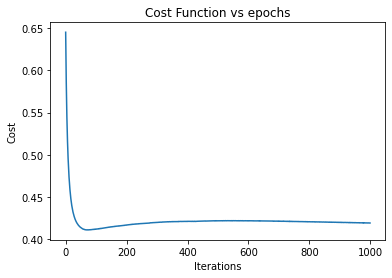

0.9767441860465116
0.971830985915493
0.9736842105263158


In [18]:
iterations = 1000
alpha_best_bgd_L1, lm_best_bgd_L1 = grid_search_bgd_L1(X_train, X_val, y_train, y_val, w, alpha_vals, iterations, lm_vals)
costs_bgd_L1, weights_bgd_L1, w_bgd_L1 = bgd_L1(X_train, y_train, w, alpha_best_bgd_L1, iterations, lm_best_bgd_L1)

pred_bgd_L1 = np.round_(sigmoid(X_test, w_bgd_L1))
TP, FN, FP, TN = confusion_matrix(pred_bgd_L1,y_test)

plot_gd(costs_bgd_L1)
pd.DataFrame(data=[[TN,FP],[FN,TP]])

SE = TP/(TP+FN)
SP = TN/(TN+FP)
Acc = (TP+TN)/(TP+TN+FP+FN)
print(SE)
print(SP)
print(Acc)

**LOR + L2 + BGD**

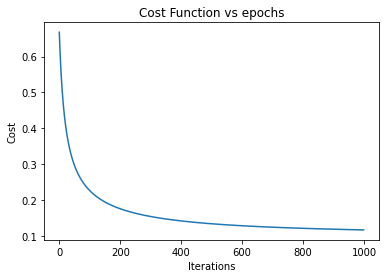

1.0
0.971830985915493
0.9824561403508771


In [19]:
alpha_best_bgd_L2, lm_best_bgd_L2 = grid_search_bgd_L2(X_train, X_val, y_train, y_val, w, alpha_vals, iterations, lm_vals)
costs_bgd_L2, weights_bgd_L2, w_bgd_L2 = bgd_L2(X_train, y_train, w, alpha_best_bgd_L2, iterations, lm_best_bgd_L2)

pred_bgd_L2 = np.round_(sigmoid(X_test, w_bgd_L2))
TP, FN, FP, TN = confusion_matrix(pred_bgd_L2,y_test)

plot_gd(costs_bgd_L2)
pd.DataFrame(data=[[TN,FP],[FN,TP]])

SE = TP/(TP+FN)
SP = TN/(TN+FP)
Acc = (TP+TN)/(TP+TN+FP+FN)
print(SE)
print(SP)
print(Acc)

**LOR + L1 + SGD**

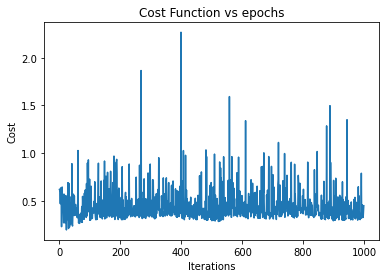

1.0
0.9436619718309859
0.9649122807017544


In [20]:
alpha_best_sgd_L1, lm_best_sgd_L1 = grid_search_sgd_L1(X_train, X_val, y_train, y_val, w, alpha_vals, iterations, lm_vals)
costs_sgd_L1, weights_sgd_L1, w_sgd_L1 = sgd_L1(X_train, y_train, w, alpha_best_sgd_L1, iterations, lm_best_sgd_L1)

pred_sgd_L1 = np.round_(sigmoid(X_test, w_sgd_L1))
TP, FN, FP, TN = confusion_matrix(pred_sgd_L1,y_test)

plot_gd(costs_sgd_L1)
pd.DataFrame(data=[[TN,FP],[FN,TP]])

SE = TP/(TP+FN)
SP = TN/(TN+FP)
Acc = (TP+TN)/(TP+TN+FP+FN)
print(SE)
print(SP)
print(Acc)

**LOR + L2 + SGD**

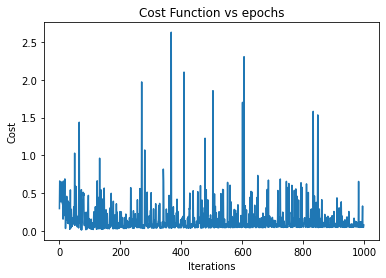

1.0
0.9859154929577465
0.9912280701754386


In [21]:
alpha_best_sgd_L2, lm_best_sgd_L2 = grid_search_sgd_L2(X_train, X_val, y_train, y_val, w, alpha_vals, iterations, lm_vals)
costs_sgd_L2, weights_sgd_L2, w_sgd_L2 = sgd_L2(X_train, y_train, w, alpha_best_sgd_L2, iterations, lm_best_sgd_L2)

pred_sgd_L2 = np.round_(sigmoid(X_test, w_sgd_L2))
TP, FN, FP, TN = confusion_matrix(pred_sgd_L2,y_test)

plot_gd(costs_sgd_L2)
pd.DataFrame(data=[[TN,FP],[FN,TP]])

SE = TP/(TP+FN)
SP = TN/(TN+FP)
Acc = (TP+TN)/(TP+TN+FP+FN)
print(SE)
print(SP)
print(Acc)

**LOR + L1 + MBGD**

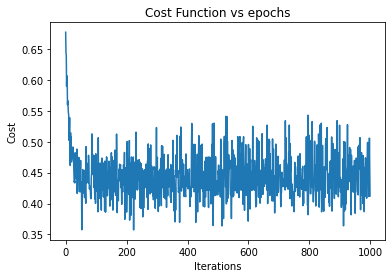

1.0
0.9436619718309859
0.9649122807017544


In [22]:
alpha_best_mbgd_L1, lm_best_mbgd_L1 = grid_search_mbgd_L1(X_train, X_val, y_train, y_val, w, alpha_vals, iterations, 50, lm_vals)
costs_mbgd_L1, weights_mbgd_L1, w_mbgd_L1 = mbgd_L1(X_train, y_train, w, alpha_best_mbgd_L1, iterations, 50, lm_best_mbgd_L1)

pred_mbgd_L1 = np.round_(sigmoid(X_test, w_mbgd_L1))
TP, FN, FP, TN = confusion_matrix(pred_mbgd_L1,y_test)

plot_gd(costs_mbgd_L1)
pd.DataFrame(data=[[TN,FP],[FN,TP]])

SE = TP/(TP+FN)
SP = TN/(TN+FP)
Acc = (TP+TN)/(TP+TN+FP+FN)
print(SE)
print(SP)
print(Acc)

**LOR + L2 + MBGD**

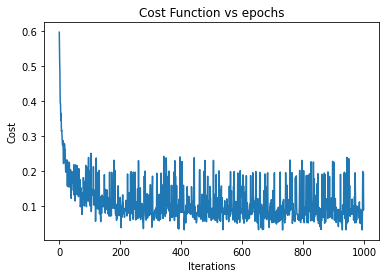

1.0
0.9859154929577465
0.9912280701754386


In [23]:
alpha_best_mbgd_L2, lm_best_mbgd_L2 = grid_search_mbgd_L2(X_train, X_val, y_train, y_val, w, alpha_vals, iterations, 50, lm_vals)
costs_mbgd_L2, weights_mbgd_L2, w_mbgd_L2 = mbgd_L2(X_train, y_train, w, alpha_best_mbgd_L2, iterations, 50, lm_best_mbgd_L2)

pred_mbgd_L2 = np.round_(sigmoid(X_test, w_mbgd_L2))
TP, FN, FP, TN = confusion_matrix(pred_mbgd_L2,y_test)

plot_gd(costs_mbgd_L2)
pd.DataFrame(data=[[TN,FP],[FN,TP]])

SE = TP/(TP+FN)
SP = TN/(TN+FP)
Acc = (TP+TN)/(TP+TN+FP+FN)
print(SE)
print(SP)
print(Acc)